# Introduction à Obspy

@D. Zigone, J. Vergne / Oct. 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Préambule

La majorité des données sismologiques sont aujourd'hui distribuées suivant un format standard international qui se decompose en 2 éléments :
- Les méta-données au format *StationXml* intégrant l'ensemble des informations relatives aux sites et aux instruments 
- Les données à proprement parlé (formes d'onde)  au format *miniseed*

Pour lire et analyser ces données dans un environnement Python, vous utiliserez la librairie **obspy**. Il s'agit d'une suite d'outils relativement complète permettant d'effectuer tout un ensemble de traitements de base de données sismologiques (dans différents formats de données dont *Miniseed*). 

Une documentation exhaustive et de nombreux exemples d'utilisation d'Obspy sont disponibles ici : https://github.com/obspy/obspy/
Vous pouvez en particulier regarder les tutoriels : https://docs.obspy.org/tutorial/ et https://krischer.github.io/seismo_live_build/tree/index.html 

---------
**Installation d'Obspy**

Si vous souhaitez utiliser *Obspy* sur vos ordinateurs personnels il faut suivre la procédure d'installation disponible ici : https://github.com/obspy/obspy/wiki#installation
Le plus simple est de disposer d'un environnement virtuel dédié via *Anaconda*.

-----------

## Chargement des modules

Dans la cellule ci-dessous nous chargeons les modules d'*Obspy* utiles par la suite

In [2]:
from obspy import read, UTCDateTime
from obspy.clients.fdsn import Client

## Récupération de données et méta-données

La plupart des grands centres de données internationaux autorisent la récupération de données à partir de *webservices* (voir https://www.fdsn.org/webservices/).

*Obspy* dispose de modules permettant de rêqueter directement des données et méta-données et les enregistrer dans des structures adaptées. Voir https://docs.obspy.org/packages/obspy.clients.fdsn.html

Par la suite, nous récupérons des données au centre de données de l'infrastructure de recherche RESIF-EPOS (voir https://www.resif.fr/ pour une présentation générale de l'infrastructure et http://seismology.resif.fr/ pour le centre de données associé). 
Nous travaillerons sur le réseau **FR** qui intègre la majorité des stations sismologiques permamentes à large bande passante sur le territoire métropolitain (voir https://rlbp.resif.fr/).


### Récupération de métadonnées

On initialise tout d'abord un *client* correspondant au centre de données choisi puis on récupère un objet de type *Inventory* pour toutes les stations du réseau sismologique *FR* 

L'option *level* permet de définir le degré d'information que l'on veut récupérer :  (“network”, “station”, “channel”, “response”)

*Attention : la requête peut être longue pour le niveau "response"*

In [28]:
client = Client("RESIF")
starttime = UTCDateTime(2021,6, 26)
inventory = client.get_stations(network="FR", station="*",starttime=starttime, level="channel")

In [29]:
inventory

Inventory created at 2021-10-19T12:46:34.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2021-06-26T00%3...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (1):
			FR
		Stations (166):
			FR.ABJF (Abjat-sur-Bandiat)
			FR.AGO (Saint-Agoulin)
			FR.AJAC (Ajaccio)
			FR.ARBF (technopole de l'Arbois)
			FR.ARTF (Artigues)
			FR.ATE (Arette)
			FR.BALS (Balsièges)
			FR.BANN (fort de Banne)
			FR.BARI (Barisis-aux-Bois)
			FR.BEGF (Béganne)
			FR.BESN (Besneville)
			FR.BETHI (Béthincourt)
			FR.BIMF (Belle-Île-en-Mer)
			FR.BLAF (Les Blancs)
			FR.BOUC (Bouclans)
			FR.BOUF (Bouguenais)
			FR.BRGF (Bourganeuf)
			FR.BSCF (Bossay-sur-Claise)
			FR.BSTF (La Bastide-des-Jourdans)
			FR.CALF (plateau de Calern)
			FR.CAMF (Camaret-sur-Mer)
			FR.CARF (Carcanières)
			FR.CFF (63014, Aubière)
			FR.CHA2 (Chamrousse)
			FR.CHIF (Chizé)
			FR.CHLF (Chalmoux)
			FR.CHMF (Charmoille)
			FR.CIEL (Vacan

L'objet *inventory* est un ensemble de listes imbriquées de type [network]/[station]/[channel]

Chaque niveau a ses propres attributs. Par exemple on peut récupérer pour chaque station sa latitude et longitude

In [4]:
#print(inventory)
sta = inventory[0][3]
print(sta)
print(sta.latitude, sta.longitude)

Station ARBF (technopole de l'Arbois)
	Station Code: ARBF
	Channel Count: 81/81 (Selected/Total)
	1998-10-26T00:00:00.000000Z - 2500-12-31T23:59:59.000000Z
	Access: open 
	Latitude: 43.49, Longitude: 5.33, Elevation: 185.0 m
	Available Channels:

43.4917 5.3325


Dans la cellule suivante on va extraire les métadonnées complètes (niveau "response") pour la station *ILLF* et afficher le gain complet de la station (passage de m/s à counts) pour le canal *HHZ*

In [5]:
inventory = client.get_stations(network="FR", station="ILLF", channel="HH*", starttime=starttime, level="response")
print(inventory)

Inventory created at 2021-10-19T10:00:24.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2021-10-01T00%3...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (1):
			FR
		Stations (1):
			FR.ILLF (Illfurth)
		Channels (3):
			FR.ILLF.00.HHZ, FR.ILLF.00.HH1, FR.ILLF.00.HH2


In [6]:
chinv = inventory[0][0][0]
#print(chinv.response)

gain = chinv.response.instrument_sensitivity.value

print(gain)

2531008392.0


## Récupération de données au format miniseed

La cellule suivante permet de récupérer une portion de 2min données à la station ILLF
pour le séisme de Strasbourg du 26 Juin 2021 à 3h00 UTC 

In [7]:
t0 = UTCDateTime(2021,6,26,3,0,0)

S = client.get_waveforms("FR", "ILLF", "00", "HH*", t0, t0 + 2*60)

print(S)

3 Trace(s) in Stream:
FR.ILLF.00.HH1 | 2021-06-26T03:00:00.004999Z - 2021-06-26T03:01:59.999999Z | 200.0 Hz, 24000 samples
FR.ILLF.00.HH2 | 2021-06-26T03:00:00.004999Z - 2021-06-26T03:01:59.999999Z | 200.0 Hz, 24000 samples
FR.ILLF.00.HHZ | 2021-06-26T03:00:00.000000Z - 2021-06-26T03:02:00.000000Z | 200.0 Hz, 24001 samples


#### Objet de type *Stream* et *Trace*

Comme l'indique la commande `print(S)`, `S` est un objet de type *Stream*.

Un tel objet *Stream* peut être vu comme une liste pouvant contenir plusieurs objets de type *Trace*. Une *Trace* correspond à un enregistrement continu sur une voie (*Z*, *N* ou *E*) à un unique capteur.

Ici il n'y a 3 *Trace* dans l'objet `S`. Pour extraire la *Trace* de la composante verticale on effectue:


In [8]:
T = S[2]

print(T)
print(type(T))

FR.ILLF.00.HHZ | 2021-06-26T03:00:00.000000Z - 2021-06-26T03:02:00.000000Z | 200.0 Hz, 24001 samples
<class 'obspy.core.trace.Trace'>


#### Métadonnées associées à une *Trace*

Les méta-données correspondant à cette *Trace* sont disponibles via la méthode *.stats* :

In [22]:
print(T.stats)
print('------')
fs = T.stats.sampling_rate # la fréquence d'échantillonnage
print('fs : ',fs)

               network: FR
               station: ILLF
              location: 00
               channel: HHZ
             starttime: 2021-06-26T03:00:40.000000Z
               endtime: 2021-06-26T03:00:58.000000Z
         sampling_rate: 200.0
                 delta: 0.005
                  npts: 3601
                 calib: 1.0
_fdsnws_dataselect_url: http://ws.resif.fr/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 9, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 118784})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2021, 6, 26, 3, 1, 59, 999999)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2021, 6, 26, 2, 59, 59, 999999))', 'ObsPy 1.2.2: trim(endtime=UTCDateTime(2021, 6, 26, 3, 0, 58)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2021, 6, 26, 3, 0, 40))', "ObsPy 1.2.2: detrend(options={}::type='dem

#### Note sur la déclaration des dates sous Obspy

Les dates (par exemple `starttime` pour celle du premier échantillon de la *Trace*) sont exprimées via des objets de type *UTCDateTime*

On peut déclarer de telles dates via la méthode `UTCDateTime` (*attention à respecter les minuscules/majuscules*) avec comme arguments : année,mois,jour,[heure],[minute],[seconde]

L'unité de base des objets de type *UTCDateTime* est la seconde


In [23]:
t0 = T.stats.starttime

print('t0 trace : ',t0)
print(type(t0))

temps = UTCDateTime(2021,9,13,12,0,0)
temps2 = temps + 120
print('temps : ',temps)
print('temps + 120s : ',temps2)

t0 trace :  2021-06-26T03:00:40.000000Z
<class 'obspy.core.utcdatetime.UTCDateTime'>
temps :  2021-09-13T12:00:00.000000Z
temps + 120s :  2021-09-13T12:02:00.000000Z


#### Accès et modification de la série temporelle

Le vecteur des données est disponible via l'attribut `.data` de l'objet *Trace*, ce vecteur données est de type *numpy.array*

Ci dessous on l'utilise pour diviser chaque échantillon par la sensibilité des nodes SmartSolo afin de convertir la trace en m/s

In [11]:
print(T.data[0:100])
T.data = T.data/gain
print('---')
print(T.data[0:100])

[-14897 -14916 -14923 -14928 -14924 -14921 -14921 -14927 -14939 -14936
 -14926 -14928 -14931 -14932 -14935 -14942 -14945 -14934 -14925 -14923
 -14903 -14892 -14906 -14903 -14897 -14931 -14962 -14942 -14936 -14955
 -14937 -14904 -14886 -14865 -14834 -14815 -14808 -14799 -14800 -14811
 -14811 -14811 -14821 -14824 -14813 -14783 -14764 -14775 -14778 -14761
 -14765 -14787 -14795 -14812 -14845 -14844 -14832 -14845 -14839 -14827
 -14829 -14826 -14829 -14837 -14854 -14869 -14862 -14863 -14854 -14837
 -14828 -14807 -14778 -14752 -14749 -14756 -14753 -14747 -14749 -14759
 -14761 -14749 -14748 -14761 -14734 -14708 -14728 -14721 -14714 -14714
 -14685 -14674 -14693 -14710 -14712 -14727 -14758 -14758 -14752 -14753]
---
[ -5.88579637e-06  -5.89330326e-06  -5.89606895e-06  -5.89804445e-06
  -5.89646405e-06  -5.89527875e-06  -5.89527875e-06  -5.89764935e-06
  -5.90239054e-06  -5.90120525e-06  -5.89725425e-06  -5.89804445e-06
  -5.89922975e-06  -5.89962485e-06  -5.90081015e-06  -5.90357584e-06
  -5.9047

## Principales méthodes des objets *Trace* (et *Stream*)

Tout l'intérêt d'*Obspy* est de disposer de méthodes/attributs déjà écrit permettant une visualation et un traitement rapide d'objets de type *Trace* ou *Stream*.

Par la suite nous en illustrons quelques-unes. 
Pour accéder à toutes les méthodes possibles il suffit d'inscrire dans une cellule de code le nom de la variable (par exemple `S`) suivie d'un point (`S.`) et d'appuyer sur la touche *tabulation*. Ou alors utiliser la commande `dir(S)`

In [12]:
dir(T)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_always_contiguous',
 '_get_response',
 '_internal_add_processing_info',
 '_ltrim',
 '_repr_pretty_',
 '_rtrim',
 'attach_response',
 'copy',
 'count',
 'data',
 'decimate',
 'detrend',
 'differentiate',
 'filter',
 'get_id',
 'id',
 'integrate',
 'interpolate',
 'max',
 'meta',
 'normalize',
 'plot',
 'remove_response',
 'remove_sensitivity',
 'resample',
 'simulate',
 'slice',
 'slide',
 'spectrogram',
 'split',
 'stats',
 'std',
 'taper',
 'times',
 'trigger',
 'trim',
 'verify',
 'write']

#### Représentation graphique 

Il s'agit de la méthode `.plot` qui dispose de nombreuses options (voir https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.plot.html)

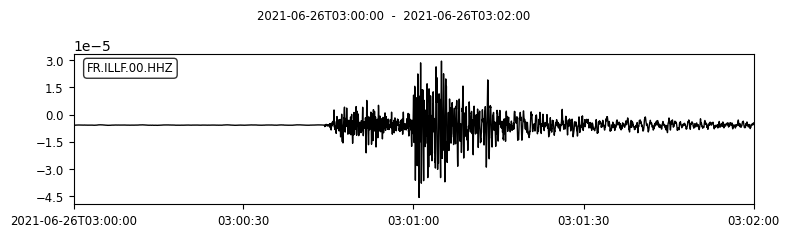

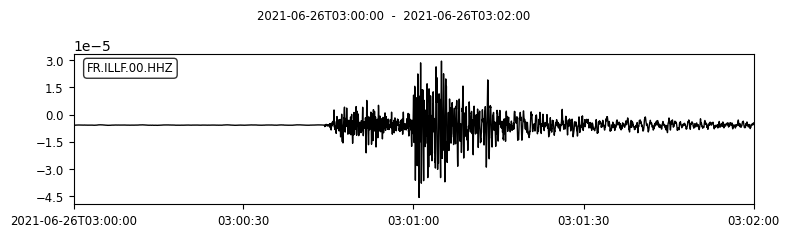

In [13]:
T.plot()

Mais pour plus de "liberté", vous pouvez utiliser directement *matplotlib.pyplot* à partir du vecteur de données `.data`

l'Objet *Trace* dispose de la méthode `.times`qui vous permet simplement d'obtenir un vecteur (*numpy.array*) temps adapté (voir les différents options)

[ -5.88579637e-06  -5.89330326e-06  -5.89606895e-06  -5.89804445e-06
  -5.89646405e-06  -5.89527875e-06  -5.89527875e-06  -5.89764935e-06
  -5.90239054e-06  -5.90120525e-06  -5.89725425e-06  -5.89804445e-06
  -5.89922975e-06  -5.89962485e-06  -5.90081015e-06  -5.90357584e-06
  -5.90476114e-06  -5.90041505e-06  -5.89685915e-06  -5.89606895e-06]
----
[ 0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04   0.045
  0.05   0.055  0.06   0.065  0.07   0.075  0.08   0.085  0.09   0.095]


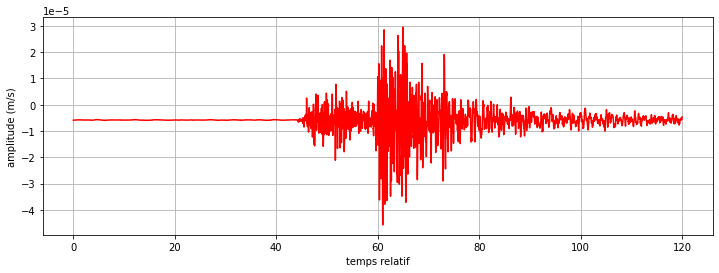

In [14]:
y = T.data
t = T.times(type='relative')

print(y[0:20])
print('----')
print(t[0:20])

plt.figure(figsize=(12,4))
plt.plot(t,y,'r')
plt.xlabel('temps relatif')
plt.ylabel('amplitude (m/s)')
plt.grid()

#### Découpage d'une portion de données

Pour cela il y a 2 possibilités :  
- la méthode `trim` qui va modifier la *Trace* originale de manière permamente ("in place")- **Attention !**
- la méthode `slice` dont le résultat doit être sauvé dans une autre variable (la *Trace* originale n'est pas modifiée)

A chaque fois il faut préciser la date du début et de fin du segment que l'on veut découper.

Par exemple pour extraire un enregistrement de 120s commençant 60s après le temps du premier échantillon :

FR.ILLF.00.HHZ | 2021-06-26T03:00:40.000000Z - 2021-06-26T03:00:58.000000Z | 200.0 Hz, 3601 samples


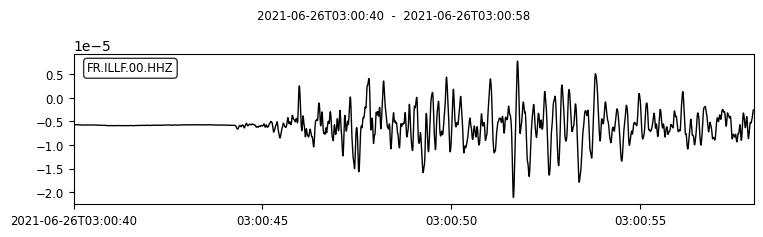

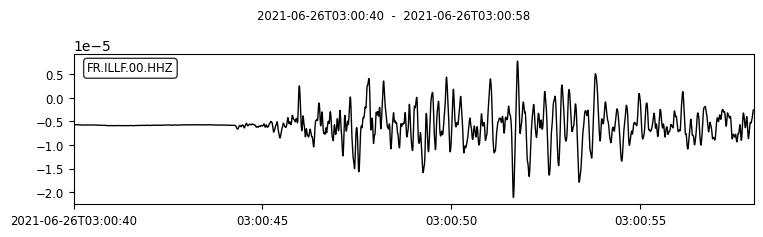

In [15]:
tc = T.stats.starttime + 40

# Option 1 (en modifiant la trace originale)
T.trim(tc,tc+18)
print(T)
T.plot()

# Option 2 (sans toucher à la trace originale)
#T2 = T.slice(tc,tc+18)
#print(T)
#print(T2)
#T2.plot()

#### Retrait de la moyenne et appodisation d'une *Trace*

*Ces deux étapes doivent être effectuées avant de filtrer une *Trace**

Pour enlever la moyenne d'une *Trace* utiliser la méthode `.detrend` (qui peut aussi enlever une tendance linéaire)

Pour effectuer une appodisation (par défaut avec une fenêtre de Hanning), utiliser la méthode `.taper` en indiquant comme paramètre le % de la trace qui sera appodisée au début et à la fin de la fenêtre.

**Attention**: la trace originale est définitivement modifiée ("in place") par ces opérations !!!
Si vous souhaitez garder la trace originale il faut d'abord la copier avec `Tkeep = T.copy()` (`Tkeep`est la version préservée de `T` même si `T`est modifié par la suite)

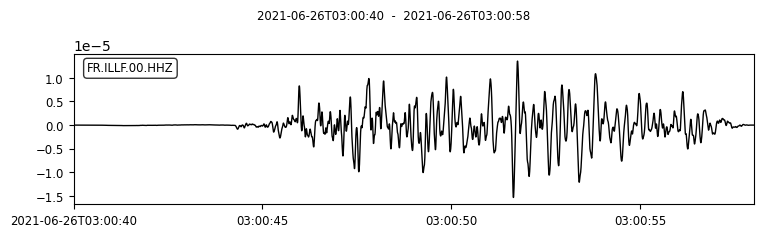

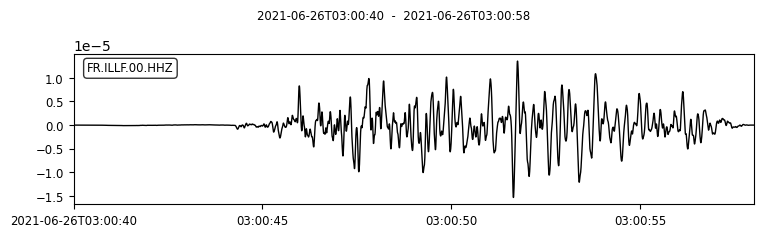

In [16]:
T.detrend("demean")
T.taper(0.1)

T.plot()

#### Filtrage d'une *Trace*

On utilise la méthode `.filter`.
Cette méthode applique un filtre de butterworth (autres disponibles !) de type *lowpass*, *highpass* ou *bandpass* (1er argument) et en spécifiant ensuite les arguments `freqmin` et/ou `freqmax`

L'exemple ci-dessous effectue un filtrage de type passe-bande entre 1 et 5 Hz

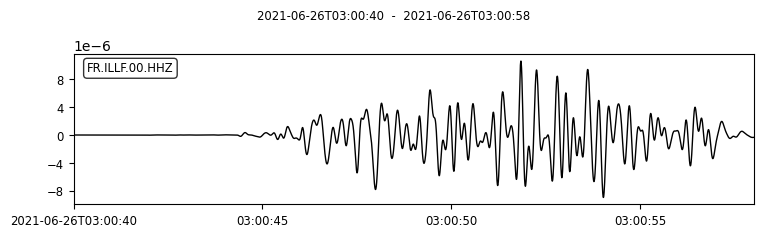

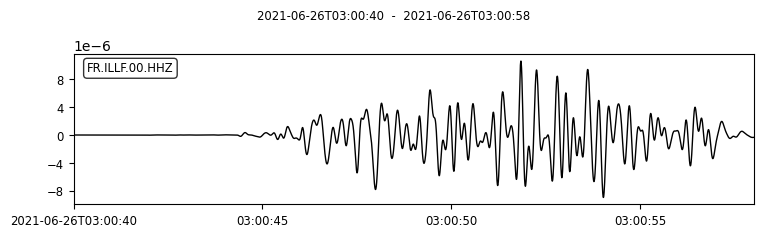

In [17]:
Tkeep = T.copy()

T.filter("bandpass",freqmin=1,freqmax=5)

T.plot()

### Spectre d'une Trace

Appliqué à la donnée initiale (non filtrée = `Tkeep`)

(0.0, 50.0)

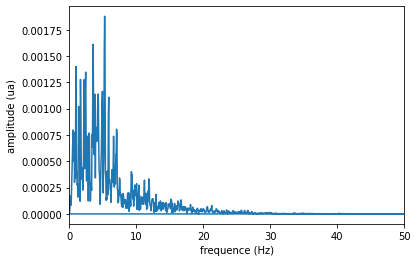

In [18]:
TFZ = np.fft.fft(Tkeep.data)
f = np.fft.fftfreq(len(TFZ),Tkeep.stats.delta)

plt.plot(f,np.abs(TFZ))
plt.xlabel('frequence (Hz)')
plt.ylabel('amplitude (ua)')
plt.xlim((0,50))

------


## Ecriture de nouveaux fichiers au format miniseed

Une fois que vous avez effectué différents traitements (découpage, filtrage, ...) vous pouvez sauvegarder votre nouvelle *Trace* dans un fichier au format miniseed via la méthode `.write`

In [19]:
fic_out = 'toto.miniseed'
T.write(fic_out,format="MSEED")

/home/definity/.local/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [20]:
TOTO = read('toto.miniseed')

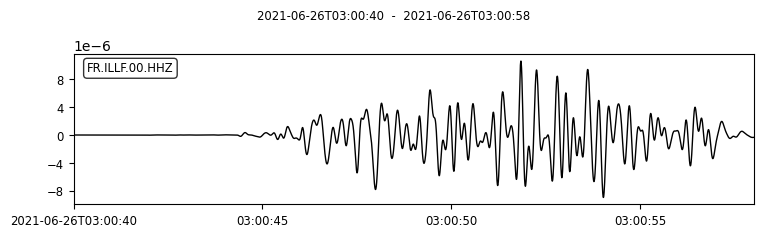

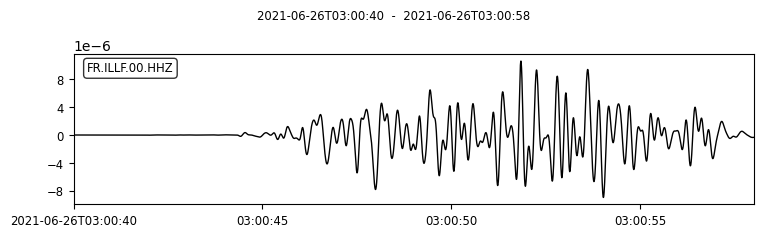

In [21]:
T.plot()